# A/B-тестирование

Перед нами стоит задача по оценке результатов проведенного A/B-теста:

* оценка корректность проведения
* анализ результата

**Техническое задание на проводимое тестирование**

* Название теста: `recommender_system_test`
* группы: А — контрольная, B — новая платежная воронка
* дата запуска: 2020-12-07
* дата остановки набора новых пользователей: 2020-12-21
* дата остановки: 2021-01-04
* аудитория: 15% новых пользователей из региона EU
* назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы
* ожидаемое количество участников теста: 6000
* ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    * конверсии в просмотр карточек товаров — событие `product_page`
    * просмотры корзины — `product_cart`
    * покупки — `purchase`

# Содержание

1. [Этап 1 - Загрузка данных](#stage_1)

  * [Вывод](#stage_1_summary)


2. [Этап 2 - Проверка корректности распределения пользователей по группам](#stage_2)
  * [Вывод](#stage_2_summary)
  

3. [Этап 3 - EDA](#stage_3)

  * [Распределение событий по времени](#stage_3_time)
  * [Среднее количество действий на каждого пользователя](#stage_3_actions)
  * [Проверка действий участников теста на соответствие ТЗ](#stage_3_excess_actions)
  * [Воронки событий](#stage_3_funnel)
  * [Расчет конверсий для целевых действий](#stage_3_target_conv)
  * [Вывод](#stage_3_summary)


4. [Этап 4 - Статистические тесты](#stage_4)

  * [Вывод](#stage_4_summary)


5. [Общий вывод](#conclusion)

Подключим библиотеки необходимые для анализа

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from statsmodels.stats.proportion import proportions_ztest

# Этап 1 - Загрузка данных<a id="stage_1"></a>

Загрузим каждый предоставленный датасет в свой датафрейм

In [2]:
marketing_events = pd.read_csv('datasets/ab_project_marketing_events.csv')
new_users = pd.read_csv('datasets/final_ab_new_users.csv')
events = pd.read_csv('datasets/final_ab_events.csv')
participants = pd.read_csv('datasets/final_ab_participants.csv')

Выведем каждый датафрейм на экран и отобразим общую информацию о нем

### marketing_events

In [3]:
marketing_events

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


In [4]:
marketing_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


Датафрейм содержит календарь маркетинговых событий на 2020 год

Структура файла:

* `name` — название маркетингового события
* `regions` — регионы, в которых будет проводится рекламная кампания
* `start_dt` — дата начала кампании
* `finish_dt` — дата завершения кампании

Данные не содержат пропусков, в колонках `start_dt` и `finish_dt` требуется изменить тип данных на временной

Замена типов

In [5]:
marketing_events['start_dt'] = pd.to_datetime(marketing_events['start_dt'])
marketing_events['finish_dt'] = pd.to_datetime(marketing_events['finish_dt'])

Проверка на дубли

In [6]:
marketing_events.duplicated().sum()

0

### new_users

In [7]:
new_users

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone
...,...,...,...,...
61728,1DB53B933257165D,2020-12-20,EU,Android
61729,538643EB4527ED03,2020-12-20,EU,Mac
61730,7ADEE837D5D8CBBD,2020-12-20,EU,PC
61731,1C7D23927835213F,2020-12-20,EU,iPhone


In [8]:
new_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


Датафрейм содержит сведения о пользователях, зарегистрировавшихя с 7 по 21 декабря 2020 года

Структура файла:

* `user_id` — идентификатор пользователя
* `first_date` — дата регистрации
* `region` — регион пользователя
* `device` — устройство, с которого происходила регистрация

Данные не содержат пропусков, в колонке `first_date` требуется изменить тип данных на временной

Замена типов

In [9]:
new_users['first_date'] = pd.to_datetime(new_users['first_date'])

Проверка на дубли

In [10]:
new_users['user_id'].duplicated().sum()

0

### events

In [11]:
events

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99
...,...,...,...,...
440312,245E85F65C358E08,2020-12-30 19:35:55,login,NaN
440313,9385A108F5A0A7A7,2020-12-30 10:54:15,login,NaN
440314,DB650B7559AC6EAC,2020-12-30 10:59:09,login,NaN
440315,F80C9BDDEA02E53C,2020-12-30 09:53:39,login,NaN


In [12]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


Датафрейм содержит записи о действиях всех новых пользователей в период с 7 декабря 2020 по 4 января 2021 года

Структура файла:

* `user_id` — идентификатор пользователя
* `event_dt` — дата и время покупки
* `event_name` — тип события
* `details` — дополнительные данные о событии, для покупок (`purchase`) в этом поле хранится стоимость покупки в долларах

В колонке `event_dt` требуется изменить тип данных на временной, для колонок `details` и `event_name` требуется проверить для каких событий отсутствуют дополнительные данные

Замена типов

In [13]:
events['event_dt'] = pd.to_datetime(events['event_dt'])

Проверка на дубли

In [14]:
events.duplicated().sum()

0

Проверим, для каких данных отсутствуют значения в поле `details`

In [15]:
events.pivot_table(index='event_name', values='details', aggfunc='count')

,details
event_name,
login,0
product_cart,0
product_page,0
purchase,62740


Для всех значений кроме данных из колонки `purchase` соответствие в колонке `details` отсутствует, это соотвествует описанию поля

### participants

In [16]:
participants

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test
...,...,...,...
18263,1D302F8688B91781,B,interface_eu_test
18264,3DE51B726983B657,A,interface_eu_test
18265,F501F79D332BE86C,A,interface_eu_test
18266,63FBE257B05F2245,A,interface_eu_test


In [17]:
participants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


Таблица участников тестов

Структура файла:

* `user_id` — идентификатор пользователя
* `ab_test` — название теста
* `group` — группа пользователя

Данные не содержат пропусков, преобразование типов не требуется

Проверка на дубли

In [18]:
participants.duplicated().sum()

0

## Вывод<a id="stage_1_summary"></a>

На первом этапе мы загрузили предоставленные данные в датафреймы, провели необходимые преобразования типов данных - в столбцах содержащих сведения о времени изменили тип на временной и проверили таблицы на дубли и пропуски (их не оказалось)

# Этап 2 - Проверка корректности распределения пользователей по группам<a id="stage_2"></a>

### Проверка распределения пользователей по тестам

Проверим количество тестов, участниками которых являются пользователи

In [19]:
participants['ab_test'].value_counts()

interface_eu_test          11567
recommender_system_test     6701
Name: ab_test, dtype: int64

Имеются записи об участии пользователей в двух тестах, нас интересует только **recommender_system_test**

Проверим сколько пользователей участвовали в обоих тестах

In [20]:
both_tests = participants.pivot_table(index='user_id', values='ab_test', aggfunc='count').reset_index()
both_tests_users = both_tests[both_tests['ab_test'] == 2]['user_id']
len(both_tests_users)

1602

1602 пользователя, удалим их из таблицы (и из обоих тестов, в том числе из целевого)

In [21]:
participants = participants.drop(participants[participants['user_id'].isin(both_tests_users)].index)

Теперь удалим из таблицы сведения о пользователях участвующих в не целевом тесте

In [22]:
round(len(participants[participants['ab_test'] == 'interface_eu_test']) / len(participants) * 100, 1)

66.2

9965 (66.2%) данных из таблицы будут удалены

In [23]:
participants = participants.drop(participants[participants['ab_test'] == 'interface_eu_test'].index)

Добавим к участникам теста информацию об их дате регистрации и регионе из таблицы `new_users`

In [24]:
participants = participants.merge(new_users, on='user_id', how='left')

### Проверка распределения по группам

Проверим во сколько групп попал каждый пользователь

In [25]:
groups_per_users = participants.pivot_table(index='user_id', values='group', aggfunc='count').reset_index()
groups_per_users['group'].value_counts()

1    5099
Name: group, dtype: int64

Все пользователи имеют по одной группе

### Проверка региона

В соответствии с техническом задании в тестировании должны были участвовать только вновь зарегистрированные пользователи из региона EU, проверим это

In [26]:
participants['region'].value_counts()

EU           4749
N.America     223
APAC           72
CIS            55
Name: region, dtype: int64

In [27]:
round(len(participants[~(participants['region'] == 'EU')]) / len(participants) * 100, 1)

6.9

350 (6.9%) пользователей из других регионов, удалим их из таблицы

In [28]:
participants = participants.drop(participants[~(participants['region'] == 'EU')].index)

### Проверка даты регистрации

В техническом задании было указано что регистрация пользователей участвующих в тесте должна быть прекращена 21.12.2020

In [29]:
participants['first_date'].value_counts().sort_index()

2020-12-07    445
2020-12-08    238
2020-12-09    172
2020-12-10    283
2020-12-11    202
2020-12-12    360
2020-12-13    415
2020-12-14    469
2020-12-15    240
2020-12-16    211
2020-12-17    250
2020-12-18    285
2020-12-19    319
2020-12-20    356
2020-12-21    504
Name: first_date, dtype: int64

Все верно

### Подсчет распределения по группам

Выведем на экран количество пользователей попавших в группы

In [30]:
users_per_group = participants.pivot_table(index='group', values='user_id', aggfunc='count')
users_per_group

,user_id
group,
A,2713
B,2036


In [31]:
round(users_per_group.loc['A', 'user_id'] / users_per_group.loc['B', 'user_id'] * 100 - 100, 1)

33.3

Группа А больше группы B на 33.3% и общее количество пользователей менее 6000 что не соответствует требованиям технического задания

## Вывод<a id="stage_2_summary"></a>

Сначала мы проверили в каких тестах участвовали наши пользователи и удалили тех которые участвовали в обоих тестах и тех которые нам не нужны - участников теста **interface_eu_test**

Мы проверили пользователей, на соответствие техническому заданию, нашли 350 неверных записей о пользователях из другого региона и удалили их

В конце мы посчитали распределение пользователей по группам теста и выяснили что группа A больше группы B на 33.8% это говорит о том что система, призванная разделять пользователей на группы, работает неверно, об этом нужно обязательно сообщить тем, кто настраивал ее

# Этап 3 - EDA<a id="stage_3"></a>

## Распределение событий по времени<a id="stage_3_time"></a>

Для оценки количества событий во времени присоединим к таблице `events` данные из таблицы `participants` с параметром 'inner' для того чтобы оставить только тех пользователей, данные о которых есть в обеих таблицах

In [32]:
events = events.merge(participants[['user_id','group']], on='user_id', how='inner')

Проверим сколько пользователей в группах у нас осталось

In [33]:
events.pivot_table(index='group', values='user_id', aggfunc=pd.Series.nunique)

,user_id
group,
A,1939
B,655


Всего 2594 пользователей совершали какие либо действия в программе после регистрации, и группа A в три раза больше группы B

Создадим специальный столбец содержащий запись о дне когда произошло событие

In [34]:
events['event_day'] = events['event_dt'].astype('datetime64[D]')

И построим гистограмму распределения количества событий по дням

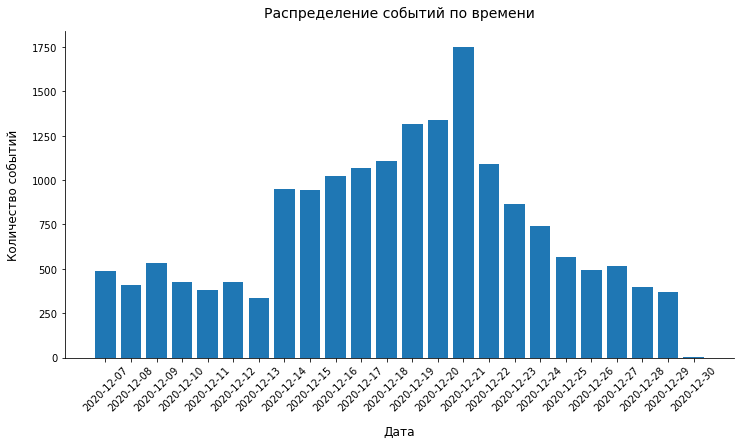

In [35]:
plt.figure(figsize=(12,6))
plt.bar(height=events.pivot_table(index='event_day', values='user_id', aggfunc='count')['user_id'],
        x=events.pivot_table(index='event_day', values='user_id', aggfunc='count').index)
plt.title('Распределение событий по времени', fontsize=14, pad=14)
plt.xlabel('Дата', fontsize=12, labelpad=12)
plt.ylabel('Количество событий', fontsize=12, labelpad=12)
plt.xticks(events.pivot_table(index='event_day', values='user_id', aggfunc='count').index, rotation=45, fontsize=10)
plt.yticks(fontsize=10)
sns.despine()
plt.show()

В середине наблюдаемого периода (на который в Европейском регионе приходится период повышенного спроса на товары перед Рождеством) наблюдается значительный рост активности пользователей

Отобразим меркетинговые события которые происходили во время теста

In [36]:
marketing_events[(marketing_events['regions'].str.contains('EU')) & 
                 (marketing_events['start_dt'] >= '2020-12-07') & 
                 (marketing_events['finish_dt'] <= '2021-01-04')]

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03


Во время проведения теста было активно одно маркетинговое мероприятие, оно могло исказить результаты проведенного тестирования

## Среднее количество действий на каждого пользователя<a id="stage_3_actions"></a>

Сгруппируем таблицу `events` по группе, id пользователя и наименованию события

In [37]:
actions_per_users = events.pivot_table(index=['group','user_id','event_name'], values='event_dt', aggfunc='count').reset_index()
actions_per_users.head()

,group,user_id,event_name,event_dt
0,A,0010A1C096941592,login,4
1,A,0010A1C096941592,product_page,4
2,A,0010A1C096941592,purchase,4
3,A,003DF44D7589BBD4,login,5
4,A,003DF44D7589BBD4,product_cart,5


Сгруппируем ее же еще раз по группе и id пользователя для того чтобы подсчитать сколько в среднем на каждого пользователя приходися действий

In [38]:
actions_per_group = events.pivot_table(index=['group','user_id'], values='event_dt', aggfunc='count').reset_index()
pd.concat([actions_per_group[actions_per_group['group'] == 'A']['event_dt'].describe(percentiles=[0.5]),
           actions_per_group[actions_per_group['group'] == 'B']['event_dt'].describe(percentiles=[0.5])], 
          axis=1, keys=['A','B']).round(2)

,A,B
count,1939.00,655.00
mean,7.09,5.78
std,3.89,3.50
min,1.00,1.00
50%,6.00,5.00
max,24.00,28.00


Пользователи из группы A проявляли больше активности в приложении

Рассчитаем среднее количество действий по видам действий

In [39]:
actions_per_users.pivot_table(index='event_name', columns='group', values='event_dt', aggfunc='mean').round(2)

group,A,B
event_name,,
login,3.14,2.78
product_cart,3.15,2.70
product_page,3.12,2.64
purchase,3.02,2.59


У пользователей из группы A активность снова выше

## Проверка действий участников теста на соответствие ТЗ<a id="stage_3_excess_actions"></a>

В соответствии с техническим заданиям для теста должны быть учтены действия тех пользователей, после регистрации которых прошло 14 дней

Отобразим количество дней о которых есть записи

In [40]:
events['event_dt'].astype('datetime64[D]').value_counts().sort_index()

2020-12-07     489
2020-12-08     408
2020-12-09     532
2020-12-10     428
2020-12-11     379
2020-12-12     423
2020-12-13     336
2020-12-14     948
2020-12-15     944
2020-12-16    1023
2020-12-17    1069
2020-12-18    1108
2020-12-19    1316
2020-12-20    1337
2020-12-21    1750
2020-12-22    1090
2020-12-23     864
2020-12-24     742
2020-12-25     567
2020-12-26     491
2020-12-27     513
2020-12-28     395
2020-12-29     372
2020-12-30       2
Name: event_dt, dtype: int64

Не смотря на то, что в ТЗ указано что тест должен был быть завершен 04.01.2021, в нашем распоряжении имеют только данные по 30.12.2020. Значит не все пользователи, зарегистрировавшиеся до 21.12.2020 могли провести в приложении 14 дней. Мы должны будем удалить всех, у кого дата регистрации была позже 16.12.2020

Добавим к таблице дату регистрации каждого пользователя

In [41]:
events = events.merge(new_users[['user_id','first_date']], on='user_id', how='left')

Посчитаем сколько действий было совершено пользователя после 14 дней с даты регистрации

In [42]:
len(events[events['event_dt'] >= (events['first_date'] + pd.Timedelta(14, 'D'))])

608

In [43]:
round(len(events[events['event_dt'] >= (events['first_date'] + pd.Timedelta(14, 'D'))]) / len(events) * 100, 1)

3.5

608 действий (3.5%) будут удалены из таблицы так как не соответствуют ТЗ

In [44]:
events = events.drop(events[events['event_dt'] >= (events['first_date'] + pd.Timedelta(14, 'D'))].index)

Посчитаем количетсво пользователей, которые не могли провести в приложении 14 дней до 30.12.2020

In [45]:
events[(events['first_date'] + pd.Timedelta(14, 'D')) > events['event_dt'].astype('datetime64[D]').max()]['user_id'].nunique()

1373

Из оставшихся 2594 пользователя мы вынуждены удалить 1373

In [46]:
events = events.drop(events[(events['first_date'] + pd.Timedelta(14, 'D')) > events['event_dt'].astype('datetime64[D]').max()].index)

Проверим распределение по группам теста

In [47]:
events.pivot_table(index='group', values='user_id', aggfunc=pd.Series.nunique)

,user_id
group,
A,844
B,377


Теперь в группе A на 45% больше чем в группе B

## Воронки событий<a id="stage_3_funnel"></a>

Рассчитаем количество дейтсвий, записи о которых остались в нашем распоряжении после чистки данных

In [48]:
events.pivot_table(index='event_name', values='user_id', aggfunc='count')

,user_id
event_name,
login,3559
product_cart,1063
product_page,2139
purchase,966


Руководствуяь бытовой логикой, воронка продаж должна выглядеть следующим образом:
1. Вход в систему
2. Просмотр страницы товара
3. Добавление товара в корзину
4. Покупка

Построим воронки событий по уникальным пользователям

In [49]:
funnel = events.pivot_table(index='event_name', columns='group', values='user_id', aggfunc=pd.Series.nunique).reset_index()
funnel['all'] = funnel['A'] + funnel['B']
funnel

group,event_name,A,B,all
0,login,844,376,1220
1,product_cart,263,95,358
2,product_page,541,203,744
3,purchase,237,104,341


Для того чтоб отсортировать воронку так, как мы считаем нужным создадим специальную категориальную переменную для которой сможем сами задавать порядок сортировки

In [50]:
funnel['event_name'] = pd.Categorical(funnel['event_name'], ['login','product_page','product_cart','purchase'])

Отсортируем воронку

In [51]:
funnel = funnel.sort_values('event_name').reset_index(drop=True)
funnel

group,event_name,A,B,all
0,login,844,376,1220
1,product_page,541,203,744
2,product_cart,263,95,358
3,purchase,237,104,341


Мы видим что в группе B событий покупки товаров на 9 больше чем событий добавления товара в корзину, это может свидетельствовать о том, что у пользователей есть возможность покупки товара "в 1 клик"

Рассчитаем конверсии пользователей при переходе по этапам воронки

In [52]:
for index in funnel.index:
    if index == 0:
        funnel.loc[index, 'A conv %'] = 100
        funnel.loc[index, 'B conv %'] = 100
        funnel.loc[index, 'all conv %'] = 100
    else:
        funnel.loc[index, 'A conv %'] = round(funnel.loc[index, 'A'] / funnel.loc[index-1, 'A'] * 100, 2)
        funnel.loc[index, 'B conv %'] = round(funnel.loc[index, 'B'] / funnel.loc[index-1, 'B'] * 100, 2)
        funnel.loc[index, 'all conv %'] = round(funnel.loc[index, 'all'] / funnel.loc[index-1, 'all'] * 100, 2)

funnel = funnel[['event_name', 'all', 'all conv %', 'A', 'A conv %', 'B', 'B conv %']]
funnel

group,event_name,all,all conv %,A,A conv %,B,B conv %
0,login,1220,100.00,844,100.00,376,100.00
1,product_page,744,60.98,541,64.10,203,53.99
2,product_cart,358,48.12,263,48.61,95,46.80
3,purchase,341,95.25,237,90.11,104,109.47


Больше всего пользователей отсекается на втором этапе, в среднем 52%. Практически все, кто добавил товар в корзину в последствии покупают его, это отличный показатель, однако он может быть искажен тем, что у пользователей есть возможность покупки товара "в 1 клик"

## Расчет конверсий для целевых действий<a id="stage_3_target_conv"></a>

Определим специальную функцию для расчета конверсии

In [53]:
def coversion_calc(event):
    trials = [funnel.loc[funnel['event_name'] == 'login', 'A'].values[0], 
              funnel.loc[funnel['event_name'] == 'login', 'B'].values[0]]
    successes = [funnel.loc[funnel['event_name'] == event, 'A'].values[0], 
                 funnel.loc[funnel['event_name'] == event, 'B'].values[0]]
    data = pd.DataFrame({'trials':trials, 'successes':successes}, index=['A','B'])
    data['conversion'] = round(data['successes'] / data['trials'] * 100, 1)
    return data

И применим ее для трех целевых действий:
1. product_page
2. product_cart
3. purchase

#### Событие product_page

In [54]:
product_page = coversion_calc('product_page')
product_page

,trials,successes,conversion
A,844,541,64.1
B,376,203,54.0


Конверсия в группе B на 10.1% ниже

#### Событие product_cart

In [55]:
product_cart = coversion_calc('product_cart')
product_cart

,trials,successes,conversion
A,844,263,31.2
B,376,95,25.3


Конверсия в группе B ниже на 5.9%

#### Событие purchase

In [56]:
purchase = coversion_calc('purchase')
purchase

,trials,successes,conversion
A,844,237,28.1
B,376,104,27.7


Здесь конверсия в группе B снова ниже, но не так значительно

## Вывод<a id="stage_3_summary"></a>

Для того, чтобы оценить распределение действий пользователей по времени и по группам мы присоединили к таблице events данные из таблицы participants с параметром 'inner' и оставили только тех пользователей, данные о которых есть в обеих таблицах, **всего 2594 пользователей совершали какие либо действия в программе после регистрации, и группа A получилась в три раза больше группы B**

Далее мы построили гистограмму распределения события по дням и увидели что **в середине наблюдаемого периода наблюдался значительный рост активности пользователей**, это может быть вызвано тем что в европейском регионе на этот период приходится сезонное увеличение спроса перед рождеством, **это может серьезно исказить результаты проведенного теста, наиболее оптимальным решением было бы отложить его проведение на январь**, но, раз тест уже завершен, продолжим анализ

Кроме предпраздничного ажитоажа **во время проведения теста было активно одно маркетинговое мероприятие**, оно также оказывало влияние на пользователей и искажало результаты тестирования

После анализа распределения событий по времени мы сравнили активность пользователей из разных групп и пришли к выводу о том что **пользователи из группы A проявляли больше активности в приложении**

Перед построеним воронок событий мы проверили действия пользователей на соответствие ТЗ, в первую очередь нужно отметить что в **нашем распоряжении имеются данные только по 30.12.2020**, хотя тест был завершен только 04.01.2021 это значит что не все пользователи, зарегистрировавшиеся до 21.12.2020 могли провести в приложении 14 дней (чего требует ТЗ)

Сначала мы удалили **608 действий (3.5%)** которые совершили пользователи **после того как были зарегистрированы 14 дней**. Далее из оставшихся 2594 пользователя мы вынуждены были **удалить 1373 тех пользователей**, дата регистрации которые была позже 16.12.2020, в связи с тем что они никак не могли провести 14 дней в качестве пользователей

В группе A получилось на **45% больше пользователей** чем в группе B

Далее мы составили воронку продаж:
1. Вход в систему
2. Просмотр страницы товара
3. Добавление товара в корзину
4. Покупка

Распределили пользователей по воронке и провели ее анализ в результате которого отметили чтов группе B событий покупки товаров на 9 больше чем событий добавления товара в корзину, это может свидетельствовать о том, что **у пользователей есть возможность покупки товара "в 1 клик"**. Расчет конверсий между этапами воронки показал что **больше всего пользователей отсекается на втором этапе, в среднем 52%**. Практически все, кто добавил товар в корзину в последствии покупают его, это отличный показатель, однако он может быть искажен тем, что у пользователей есть возможность покупки товара "в 1 клик"

На последнем этапе исследовательского анализа мы рассчитали конверсии в целевые действия и определили что **во всех случаях конверсия в группе A лучше чем в группе B**:

1. Просмотр страницы товара - разница 10.1%
2. Добавление товара в корзину - разница 5.9%
3. Покупка - разница 0.4%

# Этап 4 - Статистические тесты<a id="stage_4"></a>

Критерий значимости зададим 5%

In [57]:
alpha = 0.05

Нулевая и альтернативная гипотезы для всех тестов буду одинаковы:
* Нулевая гипотеза - между пропорциями нет статистически значимой разницы
* Альтернативная гипотеза - разница между пропорциями статистически значима

Определим функцию для проведения двустороннего z-теста

In [58]:
def z_test(data):
    p_value = proportions_ztest(data['successes'], data['trials'])[1]

    print('p-значение: ', p_value)
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу, между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными') 

#### product_page

In [59]:
z_test(product_page)

p-значение:  0.00082930890168211
Отвергаем нулевую гипотезу, между долями есть значимая разница


Разница в конверсиях (10.1%) статистически значима

#### product_cart

In [60]:
z_test(product_cart)

p-значение:  0.036790683483377024
Отвергаем нулевую гипотезу, между долями есть значимая разница


Разница в конверсиях (5.9%) статистически значима

#### purchase

In [61]:
z_test(purchase)

p-значение:  0.8797361363564222
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Разница в конверсиях (0.4%) статистически не значима

## Вывод<a id="stage_4_summary"></a>

Мы провели три статистических теста для того чтобы оценить статистическую значимость разницы конверсий в целевые события и пришли к следующим результатам:

* Разница конверсии в просмотр товара между группами A и B статистически значима
* Разница конверсии в добавлении товара в корзину между группами A и B статистически значима
* Разница конверсии в покупку товара между группами A и B статистически не значима

# Общий вывод<a id="conclusion"></a>

Мы загрузили предоставленные данные в датафреймы, провели необходимые преобразования типов данных - в столбцах содержащих сведения о времени изменили тип на временной и проверили таблицы на дубли и пропуски (их не оказалось)

Затем мы проверили в каких тестах участвовали наши пользователи и удалили тех кто участвовал в двух тестах и тех которые нам не нужны - участников теста **interface_eu_test**, и на соответствие техническому заданию: нашли 350 неверных записей о пользователях из другого региона и удалили их, после удаления пользователей мы посчитали распределение пользователей по группам теста и выяснили что группа A больше группы B на 33% это говорит о том что **система, призванная разделять пользователей на группы, работает неверно**, об этом нужно обязательно сообщить тем, кто настраивал ее

Мы оставили в таблице действий пользователей записи только о тех пользователях, которые зарегистрировались в тесте, **всего 2594 этих пользователей совершали какие либо действия в программе после регистрации, и группа A получилась в три раза больше группы B**

По гистограмме распределения событий по дням мы увидели что **в середине наблюдаемого периода наблюдался значительный рост активности пользователей**, это может быть вызвано тем что в европейском регионе на этот период приходится сезонное увеличение спроса перед рождеством, **это может серьезно исказить результаты проведенного теста, наиболее оптимальным решением было бы отложить его проведение на январь**, кроме предпраздничного ажитоажа **во время проведения теста было активно одно маркетинговое мероприятие**, оно также оказывало влияние на пользователей и искажало результаты тестирования

Перед проведением анализа действий пользователей на соответствие ТЗ нужно отметить что в **нашем распоряжении имеются данные только по 30.12.2020**, хотя тест был завершен 04.01.2021, это значит, что не все пользователи, зарегистрировавшиеся до 21.12.2020 могли провести в приложении 14 дней (требования ТЗ)

В первую очередь мы удалили **608 действий** которые совершили пользователи после того как были зарегистрированы 14 дней. Среди оставшихся пользователей мы вынуждены были удалить тех, дата регистрации которые была позже 16.12.2020 в связи с тем, что после их регистрации никак не могло пройти 14 дней и они не соответствуют требованиям ТЗ, в итоге в группе A получилось на **45% больше пользователей** чем в группе B

Далее мы составили воронку продаж:
1. Вход в систему
2. Просмотр страницы товара
3. Добавление товара в корзину
4. Покупка

Анализ построенной воронки продаж показал что в группе B событий покупки товаров на 9 больше чем событий добавления товара в корзину, это может свидетельствовать о том, что **у пользователей есть возможность покупки товара "в 1 клик"**. Расчет конверсий между этапами воронки показал что **больше всего пользователей отсекается на втором этапе, в среднем 52%**

На последнем этапе исследовательского анализа мы рассчитали конверсии в целевые действия и определили что **во всех случаях конверсия в группе A лучше чем в группе B**:

1. Просмотр страницы товара - разница 10.1%
2. Добавление товара в корзину - разница 5.9%
3. Покупка - разница 0.4%

Проведенные статистические тесты конверсий показали что 

* Разница конверсии в просмотр товара между группами A и B статистически значима
* Разница конверсии в добавлении товара в корзину между группами A и B статистически значима
* Разница конверсии в покупку товара между группами A и B статистически не значима

В итоге мы можем сказать следующее:

1. **Тест был проведен некорректно**:
  * разделение пользователей на группы сработало плохо
  * период проведения теста совпал с сезонным увеличением активности пользователей
  * в процессе проведения теста было активно маркетинговое мероприятие
  * в действиях пользователей не была отмечена покупка в один клик (она исказила воронку продаж)
  
  
2. Если оценивать результаты A/B-теста по имеющимся данным то:

  * **группа B не показала ожидаемого улучшения конверсий** (ожидалось улучшение на 10%)
  * кроме того что группа B не показала улучшения конверсий, **снижение конверсий** в "Просмотр страницы товара" и "Добавление товара в корзину" **оказалось статистически значимым**
  
  
3. **Тест нужно повторить на новых пользователях в другом периоде** (вне сезонного изменения спроса и вне периодов маркетинговых мероприятий на европейском рынке)